# 1.0 Read In Data

In [6]:
# Import libraries needed for linear regression computation
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
import scipy.stats as stats
import pylab 
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation
from sklearn.preprocessing import scale

from sklearn.model_selection import KFold
import random
%matplotlib inline

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)


Notice that the train data and the test data do not have the same number of columns. that is beacuse the train data has the SalePrice column.

# 2.0 EDA

First step is to view columns with null values. I will remove columns that have more than 90% of nulls. My gut feel is that fence is not a significant factor in determining house price so I will remove that column as well.

In [9]:
# View at nulls
null_cols = train_data.isnull().sum()
null_cols = pd.DataFrame(null_cols, columns=['count_null'])
null_cols = null_cols.sort_values(by='count_null', ascending=False)
null_cols['percent_null'] = null_cols['count_null']/train_data.shape[0]
print('these are the columns that contain nulls in them:')
print(null_cols)
null_cols = null_cols[null_cols['count_null'] > 0]

# Remove nulls > 90%
train_data = train_data.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

# Make a new null data dataframe
null_cols = train_data.isnull().sum()
null_cols = pd.DataFrame(null_cols, columns=['count_null'])
null_cols = null_cols.sort_values(by='count_null', ascending=False)
null_cols['percent_null'] = null_cols['count_null']/train_data.shape[0]
null_cols = null_cols[null_cols['count_null'] > 0]
print('deleted columns with >90% nulls:')
null_cols

these are the columns that contain nulls in them:
               count_null  percent_null
PoolQC               1453      0.995205
MiscFeature          1406      0.963014
Alley                1369      0.937671
Fence                1179      0.807534
FireplaceQu           690      0.472603
LotFrontage           259      0.177397
GarageYrBlt            81      0.055479
GarageCond             81      0.055479
GarageType             81      0.055479
GarageFinish           81      0.055479
GarageQual             81      0.055479
BsmtFinType2           38      0.026027
BsmtExposure           38      0.026027
BsmtQual               37      0.025342
BsmtCond               37      0.025342
BsmtFinType1           37      0.025342
MasVnrArea              8      0.005479
MasVnrType              8      0.005479
Electrical              1      0.000685
Id                      0      0.000000
Functional              0      0.000000
Fireplaces              0      0.000000
KitchenQual             0     

,count_null,percent_null
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtQual,37,0.025342


View the data types of the null columns. Most of the columns are null because the house does not have that specific feature. For example, houses that do not have a garage will have a null values for all garage related columns such as GarageYrBlt. 

For numeric columns such as LotFrontage and MasVnrArea, nulls can be replaced with 0. For the object columns containing nulls, nan will be replaced with 'Not Available'.

In [10]:
# View the dtypes of the columns
null_data = train_data[null_cols.index]
print(null_data.dtypes)
print(null_data.head())

train_data['LotFrontage'] = train_data['LotFrontage'].fillna(0)
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)

# Replace any null values in categorical variables with 'Not Available'
for i in train_data.columns:
    if train_data[i].dtypes == 'object':
        train_data[i] = train_data[i].fillna('Not_Available')

FireplaceQu      object
LotFrontage     float64
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
BsmtExposure     object
BsmtFinType2     object
BsmtQual         object
BsmtCond         object
BsmtFinType1     object
MasVnrArea      float64
MasVnrType       object
Electrical       object
dtype: object
  FireplaceQu  LotFrontage GarageType  GarageYrBlt GarageFinish GarageQual  \
0         NaN         65.0     Attchd       2003.0          RFn         TA   
1          TA         80.0     Attchd       1976.0          RFn         TA   
2          TA         68.0     Attchd       2001.0          RFn         TA   
3          Gd         60.0     Detchd       1998.0          Unf         TA   
4          TA         84.0     Attchd       2000.0          RFn         TA   

  GarageCond BsmtExposure BsmtFinType2 BsmtQual BsmtCond BsmtFinType1  \
0         TA           No          Unf       Gd       TA          GLQ   
1         T

Moving on to columns that are correlated with SalePrice

#### First let's take a look at all the numeric features and their correlation with SalePrice

In [11]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Drop any features that have close to 0 (+- 5) correlation with SalePrice. Will keep BsmtHalf bath to combine with other bath columns

In [12]:
train_data = train_data.drop(columns=['YrSold', 'LowQualFinSF', 'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id'])

Combine the bath features and investigate if it leads to a better correlation. Based on the output below, the combination of the bath column into 'NumBath' leads to a corelation of 0.63!

In [14]:
train_data['NumBath'] = (train_data['FullBath'] + train_data['HalfBath']/2 + 
                       train_data['BsmtHalfBath']/2 + train_data['BsmtFullBath'])

train_data = train_data.drop(columns = ['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

KeyError: 'FullBath'

Let's combine the 1st, 2nd and basement SF and investigate how it correlates with SalePrice. LivingSF has a 0.78 correlation with SalePrice. '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1' as they will have high correlation with LivingSF feature.

In [15]:
train_data['LivingSF'] = (train_data['1stFlrSF'].fillna(0) + train_data['2ndFlrSF'].fillna(0) 
                               + train_data['TotalBsmtSF'].fillna(0))

train_data = train_data.drop(columns = ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
GarageCars,0.640409
NumBath,0.631731
GarageArea,0.623431
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Let's combine the LotArea and LotFrontage features to determine if they will have a better correlation with SalePrice. TotalLotArea has a correlation of 0.26 which is slightly better than the individual correlations of LotArea and LotFrontage. Thus, LotArea and LotFrontage columns will be removed while keeping TotalLotArea

In [16]:
train_data['TotalLotArea'] = train_data['LotArea'] + train_data['LotFrontage']

train_data = train_data.drop(columns = ['LotArea', 'LotFrontage'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
GarageCars,0.640409
NumBath,0.631731
GarageArea,0.623431
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


Let's combine all the SF features that are outside of the house. For example, Garage, Porches, Pools etc that are not necessarily used for living. The addition of all the features give a correlation of 0.65. 

In [17]:
# combine total SF features outside
train_data['NonLivingSF'] = (train_data['EnclosedPorch'] + train_data['PoolArea'] + train_data['GarageArea'] + 
                             train_data['ScreenPorch'] + train_data['OpenPorchSF'] +  train_data['WoodDeckSF'])

train_data = train_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 'OpenPorchSF', 'WoodDeckSF'])
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


The MSSubClass field should be seen as a categorical variable instead of a numeric

In [18]:
train_data['MSSubClassCat'] = train_data['MSSubClass'].astype('category')

train_data = train_data.drop(columns = ['MSSubClass'])

saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


So far we have seen the correlation of all numeric variables with SalePrice. Next step is to see how all the numeric variable are corelated with each other.

From the heatmap below, (GrLivArea and LivingSF), (GarageYrBlt and YearBuilt), (OverallQual and LivingSF), (GarageCars and NonLivingSF) have a strong correlation with each other.

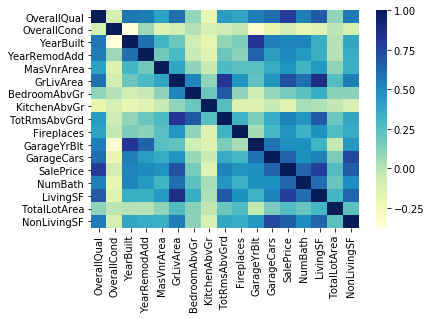

In [19]:
corr = train_data.corr()
sns.heatmap(corr, cmap="YlGnBu")

Let's take a look at the KitchenAbvGr and OverallCond columns. Based on the plots, I will delete the KitchenAbvGr as there is a large variance with houses with one kitchen. OverallCond seems like it should have a positive correlation as well, however, due to the large variance with OverallCond of 5, there is a negative correlation. OverallCond column will be deleted as well

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


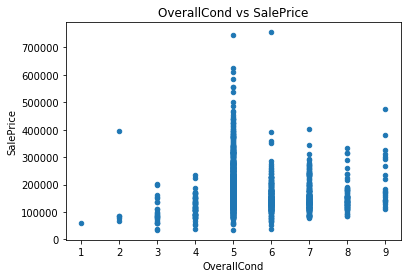

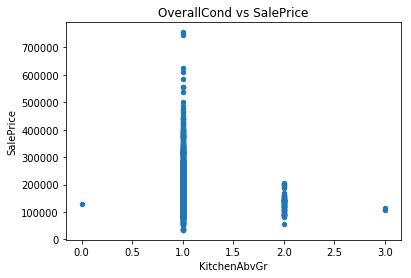

In [20]:
OverallCond_vs_SalePrice = train_data.plot(
    kind="scatter", x='OverallCond', y='SalePrice', title = "OverallCond vs SalePrice")

KitchenAbvGr_vs_SalePrice = train_data.plot(
    kind="scatter", x='KitchenAbvGr', y='SalePrice', title = "OverallCond vs SalePrice")

train_data = train_data.drop(columns = ['KitchenAbvGr', 'OverallCond'])

saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

Before we deal with features that are highly correlated with each other, let's take a look at the categorical variables. Below are all the categorical vairable columns

In [21]:
train_data.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

Removing BsmtFinType2 and BsmtFinType1 as their respective numeric features were dropped above. Furthermore, notice some features are the secondary feature of another (eg Exterior1st_VinylSd	Exterior2nd_VinylSd). The secondary feature will be removed in this case (i.e 'Exterior2nd', 'Condition2').

In [22]:
train_data = train_data.drop(columns= ['BsmtFinType1', 'BsmtFinType2', 'Exterior2nd', 'Condition2'])

Let's change 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'GarageQual', 'GarageCond' to numeric vairables (similar to OverallCond)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
ExterQualInt,0.682639
KitchenQualInt,0.659600
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
BsmtQualInt,0.604816


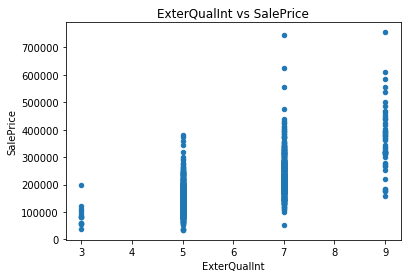

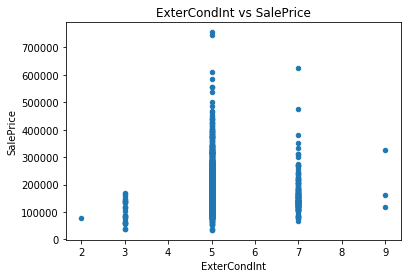

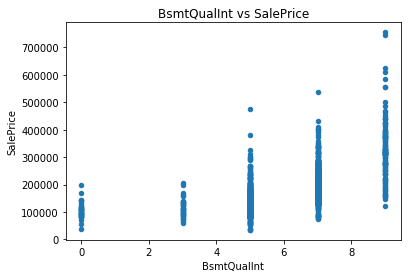

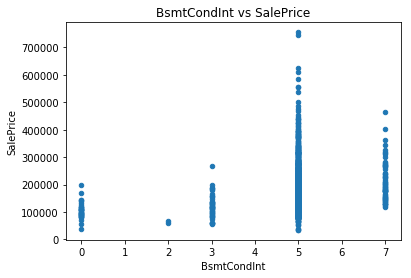

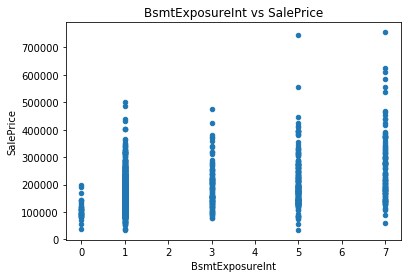

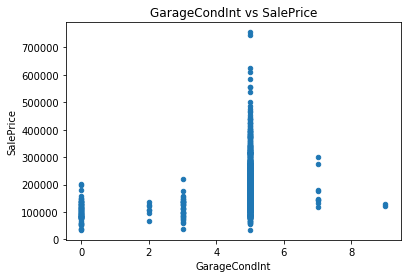

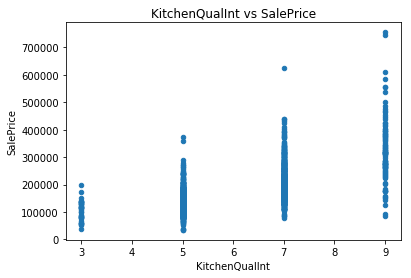

In [23]:
# Add int variables for ExterQual and ExterCond
train_data['ExterQualInt'] =  np.where(train_data['ExterQual'] == "Ex", 9, 
                                        np.where(train_data['ExterQual'] == "Gd", 7, 
                                                np.where(train_data['ExterQual'] == "TA", 5, 
                                                        np.where(train_data['ExterQual'] == "Fa", 3, 
                                                                np.where(train_data['ExterQual'] == "Po", 2,0)))))
train_data['ExterCondInt'] =  np.where(train_data['ExterCond'] == "Ex", 9, 
                                         np.where(train_data['ExterCond'] == "Gd", 7, 
                                                np.where(train_data['ExterCond'] == "TA", 5, 
                                                        np.where(train_data['ExterCond'] == "Fa", 3, 
                                                                np.where(train_data['ExterCond'] == "Po", 2,0)))))

# Add int variables for all categorical basement variables
train_data['BsmtQualInt'] =  np.where(train_data['BsmtQual'] == "Ex", 9, 
                                        np.where(train_data['BsmtQual'] == "Gd", 7, 
                                                np.where(train_data['BsmtQual'] == "TA", 5, 
                                                        np.where(train_data['BsmtQual'] == "Fa", 3, 
                                                                np.where(train_data['BsmtQual'] == "Po", 2,0)))))

train_data['BsmtCondInt'] =  np.where(train_data['BsmtCond'] == "Ex", 9, 
                                        np.where(train_data['BsmtCond'] == "Gd", 7, 
                                                np.where(train_data['BsmtCond'] == "TA", 5, 
                                                        np.where(train_data['BsmtCond'] == "Fa", 3, 
                                                                np.where(train_data['BsmtCond'] == "Po", 2,0)))))

train_data['BsmtExposureInt'] =  np.where(train_data['BsmtExposure'] == "Gd", 7, 
                                        np.where(train_data['BsmtExposure'] == "Av", 5, 
                                                np.where(train_data['BsmtExposure'] == "Mn", 3, 
                                                        np.where(train_data['BsmtExposure'] == "No", 1, 0))))

# Add int variables for GarageQual and GarageCond
train_data['GarageCondInt'] =  np.where(train_data['GarageCond'] == "Ex", 9, 
                                        np.where(train_data['GarageCond'] == "Gd", 7, 
                                                np.where(train_data['GarageCond'] == "TA", 5, 
                                                        np.where(train_data['GarageCond'] == "Fa", 3, 
                                                                np.where(train_data['GarageCond'] == "Po", 2,0)))))

train_data['GarageQualInt'] =  np.where(train_data['GarageQual'] == "Ex", 9, 
                                        np.where(train_data['GarageQual'] == "Gd", 7, 
                                                np.where(train_data['GarageQual'] == "TA", 5, 
                                                        np.where(train_data['GarageQual'] == "Fa", 3, 
                                                                np.where(train_data['GarageQual'] == "Po", 2,0)))))
# Add interaction variables for KitchenQual
train_data['KitchenQualInt'] =  np.where(train_data['KitchenQual'] == "Ex", 9, 
                                        np.where(train_data['KitchenQual'] == "Gd", 7, 
                                                np.where(train_data['KitchenQual'] == "TA", 5, 
                                                        np.where(train_data['KitchenQual'] == "Fa", 3, 
                                                                np.where(train_data['KitchenQual'] == "Po", 2,0)))))

train_data = train_data.drop(columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                                        'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])

ExterQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='ExterQualInt', y='SalePrice', title = "ExterQualInt vs SalePrice")
ExterCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='ExterCondInt', y='SalePrice', title = "ExterCondInt vs SalePrice")
BsmtQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtQualInt', y='SalePrice', title = "BsmtQualInt vs SalePrice")
BsmtCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtCondInt', y='SalePrice', title = "BsmtCondInt vs SalePrice")
BsmtExposureInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='BsmtExposureInt', y='SalePrice', title = "BsmtExposureInt vs SalePrice")
GarageCondInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='GarageCondInt', y='SalePrice', title = "GarageCondInt vs SalePrice")
KitchenQualInt_vs_SalePrice = train_data.plot(
    kind="scatter", x='KitchenQualInt', y='SalePrice', title = "KitchenQualInt vs SalePrice")
                                        
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)

Delete ExterCondInt as it has a correlation of almost 0. Based on the graphs, BsmtExposureInt, GarageCondInt and BsmtCondInt will be deleted as they visually do not have a clear linear relationship.

In [24]:
train_data = train_data.drop(columns= ['ExterCondInt', 'BsmtExposureInt', 'GarageCondInt', 'BsmtCondInt'])

Let's one hot encode the rest of the categorical variables and delete any features that have 'Not Available' present in the title

In [25]:
train_data = pd.get_dummies(train_data, drop_first=True)

# Delete any Not_Available columns (no use in the model)
train_data = train_data[train_data.columns.drop(list(train_data.filter(regex='Not_Available')))]

print('Shape of the training dataset is now:', train_data.shape)

Shape of the training dataset is now: (1460, 174)


Let look at how each feature correlates with SalePrice. I will delete all features that have 0 +- 5% correlation with SalePrice as these features will not be effective in predicting SalePrice. The following are features that will be deleted from the model:

In [26]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
saleprice_corr.sort_values(by='SalePrice', ascending = False)
saleprice_corr = saleprice_corr.reset_index()
saleprice_corr.columns = ['Feature', 'SalePrice']
features_to_delete = saleprice_corr[(saleprice_corr['SalePrice'] < 0.05) & (saleprice_corr['SalePrice'] > -0.05)]
features_to_delete 

,Feature,SalePrice
23,Street_Pave,0.041036
25,LotShape_IR3,0.036720
28,LandContour_Low,0.045528
29,LandContour_Lvl,-0.027545
30,Utilities_NoSeWa,-0.014314
32,LotConfig_FR2,-0.006859
33,LotConfig_FR3,0.018186
35,LandSlope_Mod,0.042981
36,LandSlope_Sev,0.027998
37,Neighborhood_Blueste,-0.020250


In [27]:
features_to_delete = features_to_delete['Feature'].unique()
train_data = train_data.drop(columns = features_to_delete)
print('Shape of the training dataset is now:', train_data.shape)

Shape of the training dataset is now: (1460, 111)


So far, features that have a low correlation with SalePrice have been removed from the dataset. However, collinearity between features itself must be taken care of as well.

In [28]:
saleprice_corr = train_data[train_data.columns].corr()['SalePrice']
saleprice_corr = pd.DataFrame(saleprice_corr)
# saleprice_corr = saleprice_corr.reset_index()
# saleprice_corr.columns = ['Feature', 'SalePrice']
saleprice_corr.sort_values(by='SalePrice', ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
LivingSF,0.782260
GrLivArea,0.708624
ExterQualInt,0.682639
KitchenQualInt,0.659600
NonLivingSF,0.652737
GarageCars,0.640409
NumBath,0.631731
BsmtQualInt,0.604816


The following are variables that have greater than 0.6 correlation with each other. For any features that have a correlation value greater than 90, I will remove the feature that has the least correlation with SalePrice.

In [29]:
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.60:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df
# https://onlinecourses.science.psu.edu/stat501/node/346/

,col1,col2,correlation
34,BldgType_Duplex,MSSubClassCat_90,1.000000
46,SaleType_New,SaleCondition_Partial,0.986819
33,BldgType_2fmCon,MSSubClassCat_190,0.983395
36,HouseStyle_1.5Unf,MSSubClassCat_45,0.925181
14,GrLivArea,LivingSF,0.874373
30,MSZoning_FV,Neighborhood_Somerst,0.862807
6,YearBuilt,GarageYrBlt,0.825667
12,GrLivArea,TotRmsAbvGrd,0.825489
1,OverallQual,SalePrice,0.790982
21,SalePrice,LivingSF,0.782260


I have added a for loop in the run_models_input method to remove one out of the two features with high corrleations with each other. I remove the feature that has a lower correlation with SalePrice

Let's describe the data and see if there are any outliers. First, look at the numerical features with high ranges such as LivingSF, NonLivingSF, TotalLotArea and GrLivArea. Remove outliers in the column

In [30]:
# Look at outliers
train_data.describe()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,SalePrice,NumBath,LivingSF,TotalLotArea,NonLivingSF,ExterQualInt,BsmtQualInt,GarageQualInt,KitchenQualInt,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_Reg,LandContour_HLS,LotConfig_CulDSac,LotConfig_Inside,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,RoofStyle_Gable,RoofStyle_Hip,RoofMatl_CompShg,RoofMatl_WdShngl,Exterior1st_BrkComm,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Heating_GasA,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Typ,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial,MSSubClassCat_30,MSSubClassCat_45,MSSubClassCat_50,MSSubClassCat_60,MSSubClassCat_90,MSSubClassCat_120,MSSubClassCat_160,MSSubClassCat_180,MSSubClassCat_190
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,1971.267808,1984.865753,103.117123,1515.463699,2.866438,6.517808,0.613014,1978.506164,1.767123,180921.195890,2.210616,2567.048630,10574.451370,653.658904,5.791781,6.003425,4.678082,6.023288,0.044521,0.010959,0.788356,0.149315,0.028082,0.633562,0.034247,0.064384,0.720548,0.010959,0.039726,0.019178,0.102740,0.034932,0.068493,0.025342,0.011644,0.033562,0.154110,0.028082,0.05274,0.077397,0.017123,0.050685,0.058904,0.017123,0.026027,0.007534,0.055479,0.863014,0.021233,0.035616,0.029452,0.009589,0.497260,0.304795,0.025342,0.781507,0.195890,0.982192,0.004110,0.001370,0.041781,0.152055,0.150685,0.352740,0.141096,0.017808,0.304795,0.591781,0.087671,0.434247,0.443151,0.016438,0.978082,0.004795,0.002740,0.033562,0.165068,0.293151,0.934932,0.018493,0.913699,0.003425,0.021233,0.023288,0.931507,0.260274,0.013699,0.214384,0.595890,0.060274,

Note that removing outliers for living SF made the correlation factor with SalePrice increase from 0.782260 to 0.813394

# Feature Enginerring

In [51]:
# def feature_eng(model_data, max_predictor_corr_delete, max_predictor_corr_dim_red, min_response_corr):
def feature_eng(model_data, min_corr_saleprice, corr_features_thres, is_train):

    id_col = model_data['Id']
    
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0)
    model_data['GarageCars'] = model_data['GarageCars'].fillna(0)
    model_data['LotFrontage'] = model_data['LotFrontage'].fillna(0)
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)

    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
            
    model_data['NumBath'] = (model_data['FullBath'].fillna(0) + model_data['HalfBath'].fillna(0)/2 + 
                       model_data['BsmtHalfBath'].fillna(0)/2 + model_data['BsmtFullBath'].fillna(0))
    
    
    model_data['LivingSF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))

    
    model_data['TotalLotArea'] = model_data['LotArea'] + model_data['LotFrontage']

    
    
    # combine total SF features outside
    model_data['NonLivingSF'] = (model_data['EnclosedPorch'].fillna(0) + model_data['PoolArea'].fillna(0) + 
                                 model_data['GarageArea'].fillna(0) + model_data['ScreenPorch'].fillna(0) + 
                                 model_data['OpenPorchSF'].fillna(0) +  model_data['WoodDeckSF'].fillna(0))
    
    model_data['MSSubClassCat'] = model_data['MSSubClass'].astype('category')
    
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))

    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))


    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))

    model_data = model_data.drop(columns=['EnclosedPorch', 'PoolArea', 'GarageArea', 'ScreenPorch', 
                                          'OpenPorchSF', 'WoodDeckSF', 'MSSubClass', 'KitchenAbvGr', 
                                          'OverallCond', 'BsmtFinType1', 'BsmtFinType2', 'Exterior2nd', 
                                          'Condition2', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtUnfSF',
                                          'BsmtFinSF1', 'LotArea', 'LotFrontage', 'YrSold', 'LowQualFinSF', 
                                          'MiscVal', 'BsmtFinSF2', '3SsnPorch', 'MoSold', 'Id', 'FullBath', 
                                          'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'PoolQC', 'MiscFeature', 
                                          'Alley', 'Fence', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                                          'BsmtExposure', 'GarageCond', 'GarageQual', 'KitchenQual'])
    
    model_data = pd.get_dummies(model_data, drop_first=True)

    # Delete any Not_Available columns (no use in the model)
    model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]
#     print(model_data.isnull().sum())
    if is_train:
        # Delete any variables that have less than a threshold of correlation with SalePrice
        saleprice_corr = model_data[model_data.columns].corr()['SalePrice']
        saleprice_corr = pd.DataFrame(saleprice_corr)
        saleprice_corr.sort_values(by='SalePrice', ascending = False)
        saleprice_corr = saleprice_corr.reset_index()
        saleprice_corr.columns = ['Feature', 'SalePrice']
        features_to_delete = saleprice_corr[
            (saleprice_corr['SalePrice'] < min_corr_saleprice) & (saleprice_corr['SalePrice'] > -min_corr_saleprice)]
        features_to_delete = features_to_delete['Feature'].unique()
        model_data = model_data.drop(columns = features_to_delete)
        saleprice_corr = saleprice_corr.set_index('Feature')

        # The following shows correlations of features with each other
        correlation_mat = model_data.corr()
        corr_df = []
        for i in range(0, correlation_mat.shape[0], 1):
            for j in range(i+1, correlation_mat.shape[1],1):
                if abs(correlation_mat.iloc[i,j]) >= corr_features_thres:
                    corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])
        corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
        corr_df = corr_df.sort_values(by='correlation', ascending=False)
#         print(corr_df)
        
        # Deletes one of two highly correlated features if it is greater than the threshold. Deletes feature that has
        # lower correlation with SalePrice
        for index, row in corr_df.iterrows():
            if (str(row['col1']) == 'SalePrice') or (str(row['col2']) == 'SalePrice'):
                continue
            else:
                if abs(saleprice_corr.loc[row['col1'], 'SalePrice']) >= abs(saleprice_corr.loc[row['col2'], 'SalePrice']) :
                    if row['col2'] in model_data.columns:
                        model_data = model_data.drop(columns = [row['col2']])
                else:
                    if row['col1'] in model_data.columns:
                        model_data = model_data.drop(columns = [row['col1']])
        
        model_data = model_data.drop(columns = ['SalePrice'])
    
    
    model_data_col = model_data.columns
    model_data = MinMaxScaler().fit_transform(model_data)
#     model_data = scale(model_data)
    model_data = pd.DataFrame(model_data, columns=model_data_col)
        
    return model_data, id_col
    

In [103]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
test_data, test_id = feature_eng(test_data, 0.05, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 108)
Shape of test data: (1459, 108)


# Linear Regression

In [177]:
def run_model_inputs(train_data, train_saleprice, test_data, test_id, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    log_scores = []
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
#         print(model.summary())
        # calculations to get percent error
        train_predictions = model.predict(sm.add_constant(train_X, has_constant='add'))
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        
        train_predictions = pd.DataFrame(train_predictions)
        print(train_predictions[train_predictions.loc[:,0] <= 0])

        validate_predictions = model.predict(sm.add_constant(validate_X, has_constant='add'))
        avg_validate_err = ((abs(validate_y - validate_predictions))/validate_y).mean()*100
        
        scores.append([model.rsquared_adj, avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
                       round(sqrt(mean_squared_error(train_y, train_predictions))), 
                       round(sqrt(mean_squared_error(validate_y, validate_predictions)))])

        # fitted values
        model_fitted = pd.DataFrame(model.fittedvalues)

        # model residuals
        model_residuals = pd.DataFrame(model.resid)

        # Residual plot
        residual_plot = plt.scatter(model_fitted , model_residuals)
        plt.show()

    scores = pd.DataFrame(scores, columns = ['adjr2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
    print(scores)
    print(scores.describe())
    
    final_model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit()
    
    test_predictions = final_model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return test_predictions

def run_model_inputs_pca(train_data, train_saleprice, test_data, test_id, k):
#     kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
#     print(kf)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
#         print(model.summary())
        # calculations to get percent error
        train_predictions = model.predict(sm.add_constant(train_X, has_constant='add'))
        avg_train_err = round(((abs(train_y - train_predictions))/train_y).mean()*100,2)
        
        train_predictions = pd.DataFrame(train_predictions)
#         print(train_predictions[train_predictions.loc[:,0] <= 0])

        validate_predictions = model.predict(sm.add_constant(validate_X, has_constant='add'))
        avg_validate_err = ((abs(validate_y - validate_predictions))/validate_y).mean()*100
        
        scores.append([train_X.shape[1], model.rsquared_adj, avg_train_err, avg_validate_err, 
                       abs(avg_train_err-avg_validate_err), round(sqrt(mean_squared_error(train_y, train_predictions))), 
                       round(sqrt(mean_squared_error(validate_y, validate_predictions)))])

#         # fitted values
#         model_fitted = pd.DataFrame(model.fittedvalues)

#         # model residuals
#         model_residuals = pd.DataFrame(model.resid)

#         # Residual plot
#         residual_plot = plt.scatter(model_fitted , model_residuals)
#         plt.show()

    scores = pd.DataFrame(scores, columns = ['num_components', 'adjr2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
#     print(scores)
#     print(scores.describe())
    
    final_model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit()
    test_predictions = final_model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return scores, test_predictions

In [195]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.35, 2, True)
test_data, test_id = feature_eng(test_data, 0.35, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 22)
Shape of test data: (1459, 22)


KFold(n_splits=5, random_state=33436, shuffle=True)
                0
533 -25052.227733


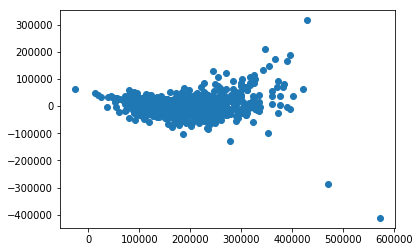

                0
533 -36602.578502


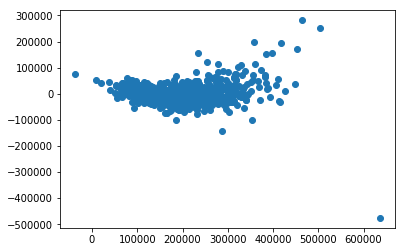

               0
533 -32767.23312


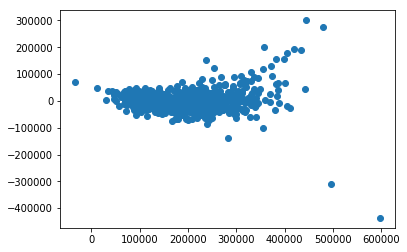

               0
533 -33475.58111


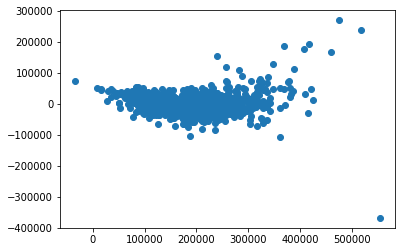

Empty DataFrame
Columns: [0]
Index: []


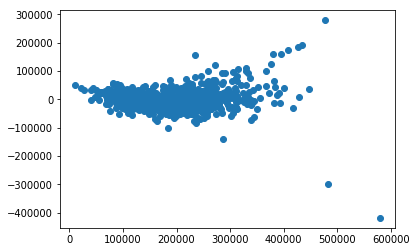

      adjr2  train_err  validate_err  diff_err  train_rmse  validate_rmse
0  0.791419      13.21     11.583134  1.626866       34480          36455
1  0.814863      13.09     14.924835  1.834835       34555          35562
2  0.801618      13.38     13.364055  0.015945       36080          28367
3  0.833364      12.80     14.715016  1.915016       32029          45624
4  0.805130      13.25     12.779675  0.470325       34379          36359
          adjr2  train_err  validate_err  diff_err    train_rmse  \
count  5.000000   5.000000      5.000000  5.000000      5.000000   
mean   0.809279  13.146000     13.473343  1.172597  34304.600000   
std    0.015860   0.219386      1.388758  0.869933   1451.671554   
min    0.791419  12.800000     11.583134  0.015945  32029.000000   
25%    0.801618  13.090000     12.779675  0.470325  34379.000000   
50%    0.805130  13.210000     13.364055  1.626866  34480.000000   
75%    0.814863  13.250000     14.715016  1.834835  34555.000000   
max    0.833

In [196]:
test_predictions = run_model_inputs(train_data, train_saleprice, test_data, test_id, 5)

In [197]:
test_predictions.to_csv('//Users//josephcolaco//predicting_house_prices//min_corr_0.35_feat_2.csv', index=False)

# Principle Component Regression

In [180]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
test_data, test_id = feature_eng(test_data, 0.05, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 108)
Shape of test data: (1459, 108)


For the first trial of pca, the data will not be centered

In [181]:
pca = PCA()
train_pca = pca.fit_transform(train_data)
test_pca = pca.fit_transform(test_data)
# print('These are the pca components:')
# pd.DataFrame(pca.components_.T)

In [183]:
# Selects 1 - length of the fit and transform pca matrix to 
score_lst = []

for i in range(1, train_pca.shape[1], 1):
    print('iter:', i)
    score, test_predictions = run_model_inputs_pca(pd.DataFrame(train_pca[:,:i]), train_saleprice, 
                                                   pd.DataFrame(test_pca[:,:i]), test_id, 5)
    score_lst.append(score.mean())

iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
iter: 35
iter: 36
iter: 37
iter: 38
iter: 39
iter: 40
iter: 41
iter: 42
iter: 43
iter: 44
iter: 45
iter: 46
iter: 47
iter: 48
iter: 49
iter: 50
iter: 51
iter: 52
iter: 53
iter: 54
iter: 55
iter: 56
iter: 57
iter: 58
iter: 59
iter: 60
iter: 61
iter: 62
iter: 63
iter: 64
iter: 65
iter: 66
iter: 67
iter: 68
iter: 69
iter: 70
iter: 71
iter: 72
iter: 73
iter: 74
iter: 75
iter: 76
iter: 77
iter: 78
iter: 79
iter: 80
iter: 81
iter: 82
iter: 83
iter: 84
iter: 85
iter: 86
iter: 87
iter: 88
iter: 89
iter: 90
iter: 91
iter: 92
iter: 93
iter: 94
iter: 95
iter: 96
iter: 97
iter: 98
iter: 99
iter: 100
iter: 101
iter: 102
iter: 103
iter: 104
iter: 105
iter: 106
iter: 107


The following plot displays the training and validation rmse values

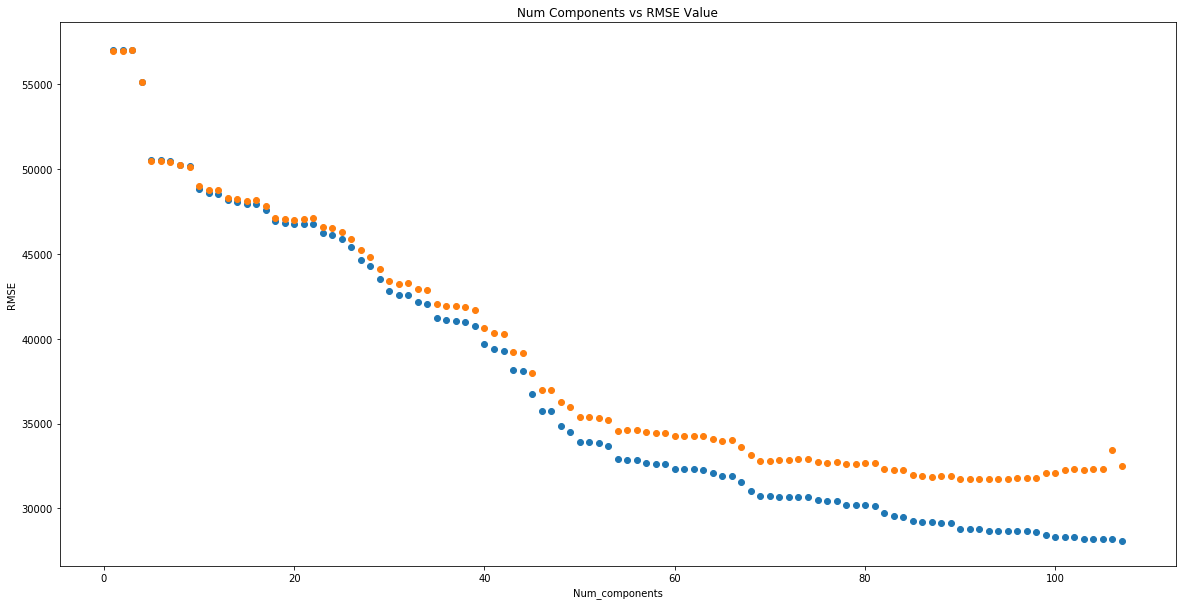

In [184]:
# Plots the train and validation rmse
score_lst_df = pd.DataFrame(score_lst)
plt.figure(figsize=(20,10))
pca_plot = plt.scatter(score_lst_df.index +1 , score_lst_df['train_rmse'])
plt.scatter(score_lst_df.index +1, score_lst_df['validate_rmse'])
plt.xlabel('Num_components')
plt.ylabel('RMSE')
plt.title('Num Components vs RMSE Value')
plt.show()

Following plot shows the difference percent in error based on the number of components:

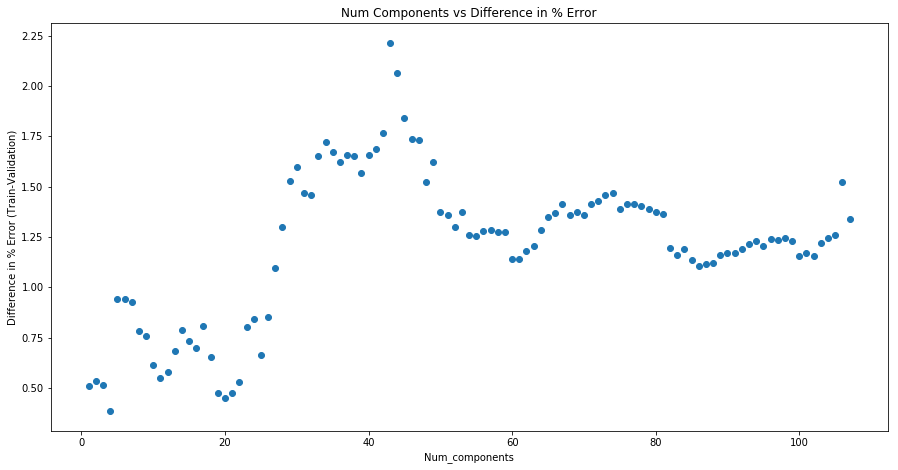

In [185]:
plt.figure(figsize=(15,7.5))
pca_plot = plt.scatter(score_lst_df.index+1 , score_lst_df['diff_err'])
plt.xlabel('Num_components')
plt.ylabel('Difference in % Error (Train-Validation)')
plt.title('Num Components vs Difference in % Error')
plt.show()

Following plot shows the difference percent in error based on the number of components filtered for percent difference error < 2

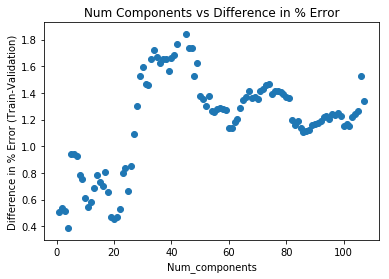

In [186]:
filtered_score_lst_df = score_lst_df[score_lst_df['diff_err'] < 2]
pca_plot = plt.scatter(filtered_score_lst_df.index+1 , filtered_score_lst_df['diff_err'])
plt.xlabel('Num_components')
plt.ylabel('Difference in % Error (Train-Validation)')
plt.title('Num Components vs Difference in % Error')
plt.show()

These are the validation metrics for different number of components

In [187]:
pd.DataFrame(score_lst)

,num_components,adjr2,train_err,validate_err,diff_err,train_rmse,validate_rmse
0,1.0,0.483517,21.898,21.938124,0.507820,57039.0,56936.2
1,2.0,0.483135,21.898,21.963021,0.534756,57035.6,56966.6
2,3.0,0.482808,21.900,21.977889,0.516522,57029.4,57019.6
3,4.0,0.515963,21.386,21.454405,0.385401,55146.6,55110.2
4,5.0,0.593024,19.692,19.733909,0.942657,50547.0,50457.0
5,6.0,0.593137,19.744,19.778212,0.941145,50518.4,50472.8
6,7.0,0.593425,19.802,19.845092,0.926979,50478.8,50442.4
7,8.0,0.596748,19.390,19.438181,0.780713,50250.2,50221.0
8,9.0,0.597864,19.376,19.428556,0.755969,50158.8,50129.4
9,10.0,0.618408,18.392,18.497673,0.612961,48840.0,48997.0


Following displays the variance explained in the model

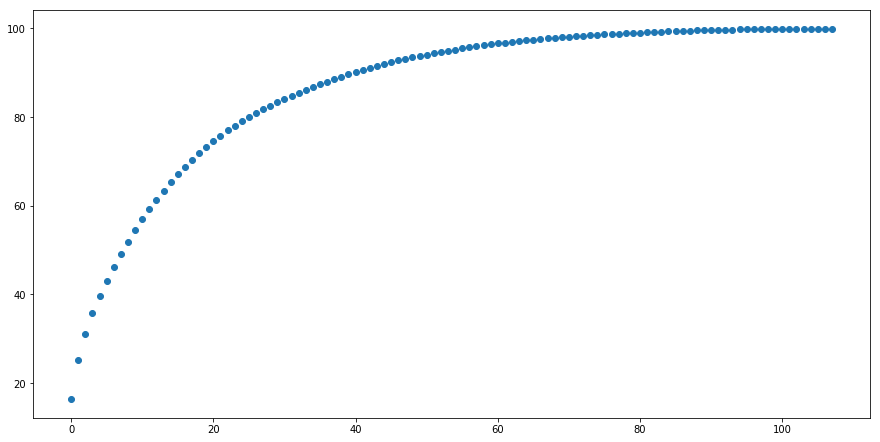

In [188]:
# Following displays the variance explained in the model
a = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
a = pd.DataFrame(a, columns=['var_explained'])
plt.figure(figsize=(15,7.5))
var_explained_plot = plt.scatter(a.index , a['var_explained'])
plt.show()

this graphs shows difference in variance explained (like an elbow method graph)

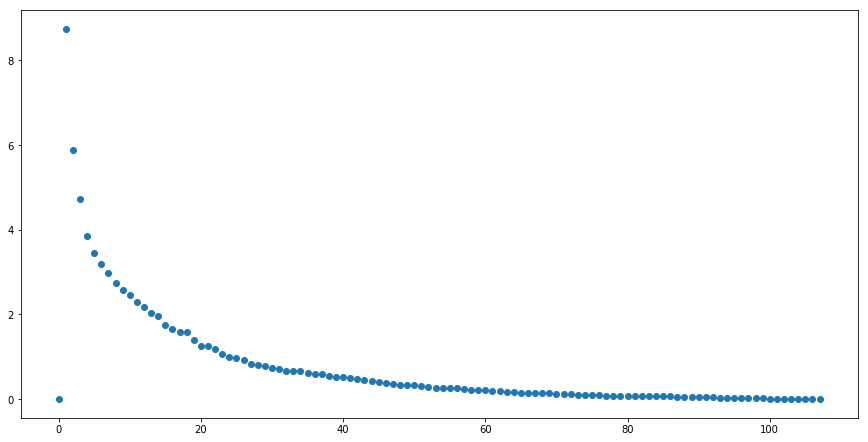

In [189]:
# Following displays the variance explained in the model
a = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
a = pd.DataFrame(a, columns=['var_explained'])

for index, row in a.iterrows():
    if index == 0:
        continue
    a.loc[index, 'diff_var_explained'] = a.loc[index, 'var_explained'] - a.loc[index-1, 'var_explained']

a['diff_var_explained'] = a['diff_var_explained'].fillna(0)
plt.figure(figsize=(15,7.5))
var_explained_plot = plt.scatter(a.index , a['diff_var_explained'])
plt.show()

# Partial Least Squares Regression

In [253]:
def run_model_inputs_pls(train_data, train_saleprice, k, pls_component_no):
    kf = KFold(n_splits=k, shuffle=True, random_state=round(random.uniform(1, 40000)))
    # kf = KFold(n_splits=10, shuffle=True, random_state=6104)
    kf.get_n_splits(train_data)
    print(kf)
    scores = []
    for train_index, test_index in kf.split(train_data):
        train_X, validate_X = train_data.loc[train_index,:], train_data.loc[test_index,:]
        train_y, validate_y = train_saleprice.loc[train_index], train_saleprice.loc[test_index]
        
        pls2 = PLSRegression(copy=True, max_iter=500, n_components=pls_component_no, scale=False, tol=1e-06)
        pls2.fit(sm.add_constant(train_X, has_constant='add'), train_y)
        r2 = pls2.score(sm.add_constant(train_X, has_constant='add'), train_y)
#         print(r2)
        
        train_predictions = pd.DataFrame(
            pls2.predict(sm.add_constant(train_X, has_constant='add')))
        train_predictions.columns = ['PredSalePrice']
        
        train_y = pd.DataFrame(train_y).reset_index(drop=True)
        train_predictions['SalePrice'] = train_y['SalePrice']
        train_predictions['err'] = train_predictions['PredSalePrice'] - train_y['SalePrice']
        train_predictions['percent_err'] = (abs(train_predictions['err'])/train_predictions['SalePrice'])
#         print(train_predictions)
        
#         # calculations to get percent error
        avg_train_err = round((abs(train_predictions['err'])/train_predictions['SalePrice']).mean()*100,2)
#         print('Train % error:', avg_train_err)

        validate_predictions = pd.DataFrame(
            pls2.predict(sm.add_constant(validate_X, has_constant='add')))
        
        validate_predictions.columns = ['PredSalePrice']
        validate_y = pd.DataFrame(validate_y).reset_index(drop=True)
        validate_predictions['SalePrice'] = validate_y['SalePrice']
        validate_predictions['err'] = validate_predictions['PredSalePrice'] - validate_y['SalePrice']
        validate_predictions['percent_err'] = (abs(validate_predictions['err'])/validate_predictions['SalePrice'])
#         print(validate_predictions)
        # calculations to get percent error
        avg_validate_err = round((abs(validate_predictions['err'])/validate_predictions['SalePrice']).mean()*100,2)
#         print('Validate % error:', avg_validate_err)
        
        scores.append([r2, avg_train_err, avg_validate_err, abs(avg_train_err-avg_validate_err),
                       round(sqrt(mean_squared_error(train_predictions['SalePrice'], train_predictions['PredSalePrice']))), 
                       round(sqrt(mean_squared_error(validate_predictions['SalePrice'], validate_predictions['PredSalePrice'])))])

#         # fitted values
#         model_fitted = pd.DataFrame(model.fittedvalues)

#         # model residuals
#         model_residuals = pd.DataFrame(model.resid)

#         # Residual plot
#         residual_plot = plt.scatter(model_fitted , model_residuals)
#         plt.show()

    scores = pd.DataFrame(scores, columns = ['r2', 'train_err', 'validate_err', 'diff_err', 
                                             'train_rmse', 'validate_rmse'])
#     print(scores)
#     print(scores.describe())
    

#     test_predictions = model.predict(sm.add_constant(test_data))
#     test_predictions = pd.DataFrame(test_predictions)
#     test_predictions.columns = ['SalePrice']
#     test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
#     return test_predictions
    return scores

In [254]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.05, 2, True)
test_data, test_id = feature_eng(test_data, 0.05, 2, False)

for i in train_data.columns:
    if i not in test_data.columns:
        train_data = train_data.drop(columns = i)
print('Shape of train data:', train_data.shape)
test_data = test_data[train_data.columns]
print('Shape of test data:', test_data.shape)

Shape of train data: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 108)
Shape of test data: (1459, 108)


In [255]:
scores = run_model_inputs_pls(train_data, train_saleprice, 5, 40)
scores.mean()

KFold(n_splits=5, random_state=36631, shuffle=True)


r2                   0.875462
train_err           10.254000
validate_err        11.810000
diff_err             1.556000
train_rmse       27995.000000
validate_rmse    33382.800000
dtype: float64

In [258]:
# Selects 1 - length of the fit and transform pca matrix to 
score_lst = []

for i in range(1, train_data.shape[1], 1):
    print('iter:', i)
    score = run_model_inputs_pls(train_data, train_saleprice, 5, i)
    score_lst.append(score.mean())
    
score_lst_df = pd.DataFrame(score_lst)

iter: 1
KFold(n_splits=5, random_state=33439, shuffle=True)
iter: 2
KFold(n_splits=5, random_state=2111, shuffle=True)
iter: 3
KFold(n_splits=5, random_state=18068, shuffle=True)
iter: 4
KFold(n_splits=5, random_state=34583, shuffle=True)
iter: 5
KFold(n_splits=5, random_state=24440, shuffle=True)
iter: 6
KFold(n_splits=5, random_state=30476, shuffle=True)
iter: 7
KFold(n_splits=5, random_state=31666, shuffle=True)
iter: 8
KFold(n_splits=5, random_state=18661, shuffle=True)
iter: 9
KFold(n_splits=5, random_state=11907, shuffle=True)
iter: 10
KFold(n_splits=5, random_state=33229, shuffle=True)
iter: 11
KFold(n_splits=5, random_state=6961, shuffle=True)
iter: 12
KFold(n_splits=5, random_state=28197, shuffle=True)
iter: 13
KFold(n_splits=5, random_state=8961, shuffle=True)
iter: 14
KFold(n_splits=5, random_state=407, shuffle=True)
iter: 15
KFold(n_splits=5, random_state=38576, shuffle=True)
iter: 16
KFold(n_splits=5, random_state=26866, shuffle=True)
iter: 17
KFold(n_splits=5, random_stat

/anaconda3/lib/python3.6/site-packages/sklearn/cross_decomposition/pls_.py:313: UserWarning: X scores are null at iteration 106
  warnings.warn('X scores are null at iteration %s' % k)


In [259]:
score_lst_df

,r2,train_err,validate_err,diff_err,train_rmse,validate_rmse
0,0.567894,19.688,19.748,0.744,52193.2,52244.8
1,0.711530,16.258,16.686,1.012,42643.0,43333.4
2,0.791174,14.104,14.512,0.640,36274.6,37665.0
3,0.814958,13.378,14.182,0.912,34152.6,35995.8
4,0.837790,12.548,13.232,1.376,31961.8,34001.2
5,0.846550,12.126,12.844,0.850,31080.2,32873.8
6,0.854455,11.602,12.546,0.956,30288.8,32417.0
7,0.857860,11.432,12.176,0.908,29930.8,32056.2
8,0.861562,11.210,12.172,1.074,29515.0,32334.6
9,0.865022,11.046,12.062,1.080,29156.6,32180.8


In [ ]:
# Apply regulization and then add zeros to the feature engineering method

In [25]:
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print('Shape of train data before:', train_data.shape)
print('Shape of test data:', test_data.shape)

train_saleprice = train_data['SalePrice']
train_data, train_id = feature_eng(train_data, 0.3, 0.75, True)
print('Shape of train data:', train_data.shape)
print(train_data.columns)

model = sm.OLS(train_saleprice, sm.add_constant(train_data)).fit_regularized(method='elastic_net', alpha=1000, L1_wt =1)
print('Taking out:', model.params[model.params == 0].shape[0]/model.params.shape[0])
print(model.params[model.params == 0])

Shape of train data before: (1460, 81)
Shape of test data: (1459, 80)
Shape of train data: (1460, 25)
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces',
       'GarageCars', 'NumBath', 'LivingSF', 'NonLivingSF', 'ExterQualInt',
       'BsmtQualInt', 'KitchenQualInt', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Exterior1st_VinylSd', 'MasVnrType_None',
       'MasVnrType_Stone', 'Foundation_PConc', 'HeatingQC_TA',
       'FireplaceQu_Gd', 'GarageType_Attchd', 'GarageType_Detchd',
       'GarageFinish_Unf', 'SaleType_New', 'MSSubClassCat_60'],
      dtype='object')
Taking out: 0.5384615384615384
const                  0.0
YearBuilt              0.0
MasVnrArea             0.0
LivingSF               0.0
NonLivingSF            0.0
ExterQualInt           0.0
BsmtQualInt            0.0
KitchenQualInt         0.0
Exterior1st_VinylSd    0.0
MasVnrType_None        0.0
MasVnrType_Stone       0.0
Foundation_PConc       0.0
GarageType_Attchd      0.0
MSSubClas

In [ ]:
# Try combining features and see if it makes the model better

# K-NN

In [ ]:
# August 28th
# Understand and Finsih PCA regression
# try top 3 model submissions
# Try PLS